<a href="https://colab.research.google.com/github/Johann-Huber/batchnorm_pytorch/blob/main/batch_normalization_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple implementation of Batch Normalization (using Pytorch)

This notebook provides : 
* A simple implementation of BN (applied to an MLP) using Pytorch ;
* Reproduction of the MNIST-based results presented in the original paper.

---

MNIST is a small dataset, and the MLP described in the paper is not so deep (3 hidden layers). 

As a result, Batch Normalization effects are not so easy to see, compared to larger datasets and deeper networks.

Here are some insights to emphasize one BN property or another :
* Lower learning rate stresses the BN impact on training speed ;
* Higher learning rate stresses the BN impact on activation smoothness.
* Normalizing the input vector of the model makes the optimization problem easier : on such a simple task, we can see any difference of hidden layer activation values between the BN-based model and the standard on. Removing the normalization of the model's input makes the optimization problem more difficult, emphasizing the BN smoothing effect on hidden layers activation.

---
Reference

Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift, arXiv preprint arXiv:1502.03167.


------

In [1]:
# Hypeparameters

LR_BASE = 0.01 #lr baseline
LR_BN = 0.01 #lr bn network

num_iterations = 10000 #50000
valid_steps = 50 # training iterations before validation

verbose = True
   


------------

In [2]:
# Libs
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Import the MINST dataset

transform_imgs = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize( # Not mentionned in the paper. No normalization
                                 (0.1307,), (0.3081,))])         # emphasizes the smoothing effect on hidden layers
                                                                 # activation.

mnist_trainset = datasets.MNIST(root='./data', 
                                train=True, 
                                download=True, 
                                transform=transform_imgs)

mnist_testset = datasets.MNIST(root='./data', 
                               train=False, 
                               download=True, 
                               transform=transform_imgs)

In [4]:
## Dataset loader


train_loader_params = {'shuffle': True, 'batch_size' : 60, 'drop_last' : False}
test_loader_params = {'shuffle': False, 'batch_size' : 60, 'drop_last' : False}

train_loader = DataLoader(mnist_trainset, **train_loader_params )
test_loader = DataLoader(mnist_testset, **test_loader_params )

# Each batch : (imgs, targets)
#    imgs : (batch_size=60, channels=1, height=28, width=28) tensor (float32)
#    targets : (batch_size=60) tensor (int64)


In [5]:
## BatchNorm reimplementation

class myBatchNorm2d(nn.Module):
    def __init__(self, input_size = None , epsilon = 1e-3, momentum = 0.99):
        super(myBatchNorm2d, self).__init__()
        assert input_size, print('Missing input_size parameter.')
        
        # Batch mean & var must be defined during training
        self.mu = torch.zeros(1, input_size)
        self.var = torch.ones(1, input_size)
        
        # For numerical stability
        self.epsilon = epsilon
        
        # Exponential moving average for mu & var update 
        self.it_call = 0  # training iterations
        self.momentum = momentum # EMA smoothing
        
        # Trainable parameters
        self.beta = torch.nn.Parameter(torch.zeros(1, input_size))
        self.gamma = torch.nn.Parameter(torch.ones(1, input_size))
        
        # Batch size on which the normalization is computed
        self.batch_size = 0

        
    def forward(self, x):
        # [batch_size, input_size]
        
        self.it_call += 1
        
        if self.training :
            
            if( self.batch_size == 0 ):
                # First iteration : save batch_size
                self.batch_size = x.shape[0]
            
            # Training : compute BN pass
            batch_mu = (x.sum(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            batch_var = (x.var(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            
            x_normalized = (x-batch_mu)/torch.sqrt(batch_var + self.epsilon) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
            
            
            # Update mu & std 
            if(x.shape[0] == self.batch_size):
                running_mu = batch_mu
                running_var = batch_var
            else:
                running_mu = batch_mu*self.batch_size/x.shape[0]
                running_var = batch_var*self.batch_size/x.shape[0]
 
            self.mu = running_mu * (self.momentum/self.it_call) + \
                            self.mu * (1 - (self.momentum/self.it_call))
            self.var = running_var * (self.momentum/self.it_call) + \
                        self.var * (1 - (self.momentum/self.it_call))
            
        else:
            # Inference : compute BN pass using estimated mu & var
            if (x.shape[0] == self.batch_size):
                estimated_mu = self.mu
                estimated_var = self.var
            else :
                estimated_mu = self.mu*x.shape[0]/self.batch_size
                estimated_var = self.var*x.shape[0]/self.batch_size
                
            x_normalized = (x-estimated_mu)/torch.sqrt(estimated_var + self.epsilon) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
    
        return x_bn # [batch_size, output_size=input_size]


In [6]:
class ActivationTracker(nn.Module):
    '''Identity module, which keep track of the current activation during validation.'''
    
    def __init__(self):
        super(ActivationTracker, self).__init__()

        # Keep tack of [0.15, 0.5, 0.85] percentiles
        self.percents_activation_track = [15, 50, 85]
        self.all_percents_activation = []

    def get_all_activations(self):
        return np.array(self.all_percents_activation)
        
    def forward(self, x):
        
        if not self.training :
            percents_activation = np.percentile(x.detach().flatten(), self.percents_activation_track)
            self.all_percents_activation.append(percents_activation)
            #print('percents_activation = ', percents_activation)
        
        return x


In [7]:
## Networks

def init_weights(model):
    for module in model:
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, mean=0.0, std=1.0) # "Random Gaussian value"
            #torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.)


input_size = 784

# Baseline
baseline_model = nn.Sequential(nn.Linear(input_size,100), #1
                      nn.Sigmoid(),
                      nn.Linear(100,100), #2
                      nn.Sigmoid(),
                      nn.Linear(100,100), #3
                      ActivationTracker(),
                      nn.Sigmoid(),
                      nn.Linear(100,10) # out
                     )

init_weights(baseline_model)


        
# BN model
bn_model = nn.Sequential(nn.Linear(input_size,100), #1
                      myBatchNorm2d(100),
                      nn.Sigmoid(),
                      nn.Linear(100,100), #2
                      myBatchNorm2d(100),
                      nn.Sigmoid(),
                      nn.Linear(100,100), #3
                      myBatchNorm2d(100),
                      ActivationTracker(),
                      nn.Sigmoid(),
                      nn.Linear(100,10) # out
                     )

init_weights(bn_model)
    



In [8]:
# Loss & metrics
criterion = nn.CrossEntropyLoss()
metric = accuracy_score

In [9]:
def valid_loop(model, valid_loader, criterion, metric, epoch, verbose = True):
    
    sum_loss = 0
    sum_score = 0
    
    for it, (imgs, targets) in enumerate(valid_loader, start=1):
        imgs = imgs.view(-1,784)
        
        with torch.no_grad():
            out = model(imgs) # [batch_size,num_class]
            preds  = torch.argmax(out.detach(), dim=1) # [batch_size]

            loss = criterion(out,targets)
            score = metric(targets, preds)

                    
            sum_loss += loss
            sum_score += score
            
    return sum_score/it, sum_loss/it

In [10]:
## Training models


def train_loop(model, train_loader, valid_loader, optimizer, scheduler, criterion, metric, verbose = True):

    # Loss & metric lists
    valid_stats = []
    epochs_valid_stats = []

    with tqdm(range(num_epochs), desc = "Train epochs") as epochs_bar :
      for e in epochs_bar:
          
          # Training
          with tqdm(train_loader, leave=False) as it_bar:
            for it, (imgs, targets) in enumerate(it_bar, start=1):
                imgs = imgs.view(-1,784)

                out = model(imgs) # [batch_size,num_class]
                preds  = torch.argmax(out.detach(), dim=1) # [batch_size]

                loss = criterion(out,targets)
                score = metric(targets, preds)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if(it % valid_steps == 0):
                    # Validation
                    model.eval()
                    valid_score, valid_loss = valid_loop(model, valid_loader, criterion, metric, e, verbose)
                    valid_stats.append([valid_score.astype(np.float32), \
                                        valid_loss.detach().numpy().astype(np.float32)])
                    epochs_valid_stats.append(it+e*len(train_loader))
                    
                    if(verbose):
                      it_bar.set_postfix(valid_loss=valid_loss.item(), valid_score=valid_score)

                    model.train()

            scheduler.step()

    return np.array(valid_stats), epochs_valid_stats



def init_optim_and_scheduler(model, lr = 0.1):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) # momentum not mentioned
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10) # Not mentioned in the paper
    return optimizer, scheduler





    
#---------------------------
# Training loops
#---------------------------

num_epochs = int(num_iterations/len(train_loader))


## Without BN
print('-'*15, 'BASELINE MODEL', '-'*15)
optimizer, scheduler = init_optim_and_scheduler(baseline_model, lr = LR_BASE)
valid_stats_base, epochs_stats = train_loop(baseline_model, train_loader, test_loader, \
                                            optimizer, scheduler, criterion, metric, verbose = verbose)

## With BN
print('-'*15, 'BATCH NORMALIZED MODEL', '-'*15)
optimizer, scheduler = init_optim_and_scheduler(bn_model, lr = LR_BN)
valid_stats_bn, epochs_stats = train_loop(bn_model, train_loader, test_loader, \
                                          optimizer, scheduler, criterion, metric, verbose = verbose)




--------------- BASELINE MODEL ---------------



--------------- BATCH NORMALIZED MODEL ---------------


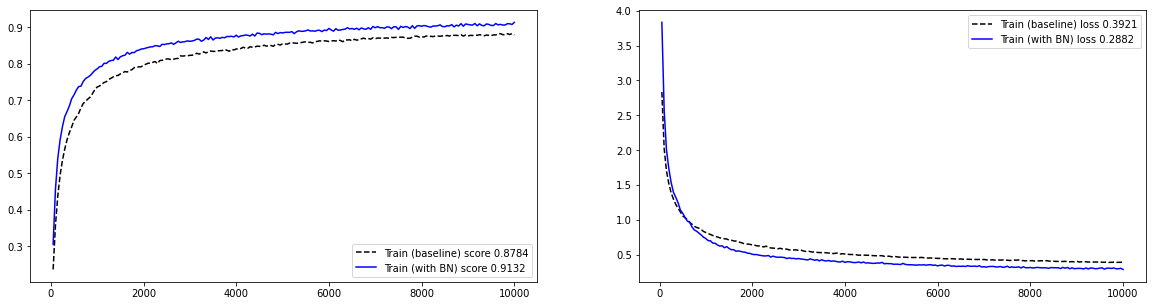

In [11]:


if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))
    #ax.clear()
    
    # Scores
    ax[0].plot(epochs_stats, valid_stats_base[:, 0], 'k--', \
               label = f"Train (baseline) score {valid_stats_base[-1, 0]:.4f}")
    ax[0].plot(epochs_stats, valid_stats_bn[:, 0], 'b-', \
               label = f"Train (with BN) score {valid_stats_bn[-1, 0]:.4f}")
    
    # Losses
    ax[1].plot(epochs_stats, valid_stats_base[:, 1], 'k--', \
               label = f"Train (baseline) loss {valid_stats_base[-1, 1]:.4f}")
    ax[1].plot(epochs_stats, valid_stats_bn[:, 1], 'b-', \
               label = f"Train (with BN) loss {valid_stats_bn[-1, 1]:.4f}")
    
    ax[0].legend(); ax[1].legend()
    plt.show()


In [12]:

# Get last hidden layer activation
baseline_activation = baseline_model[5].get_all_activations()
bn_activation = bn_model[8].get_all_activations()

# Reshape from [num_call_valid_bn,3] to [num_call_valid, num_test_batches, 3]
num_call_valid = len(epochs_stats)
num_test_batches = len(test_loader)
baseline_activation = np.reshape(baseline_activation, (num_call_valid,num_test_batches,3))
bn_activation = np.reshape(bn_activation, (num_call_valid,num_test_batches,3))

# Get mean over all the test batches
baseline_activation = np.mean(baseline_activation, axis=1)
bn_activation = np.mean(bn_activation, axis=1)


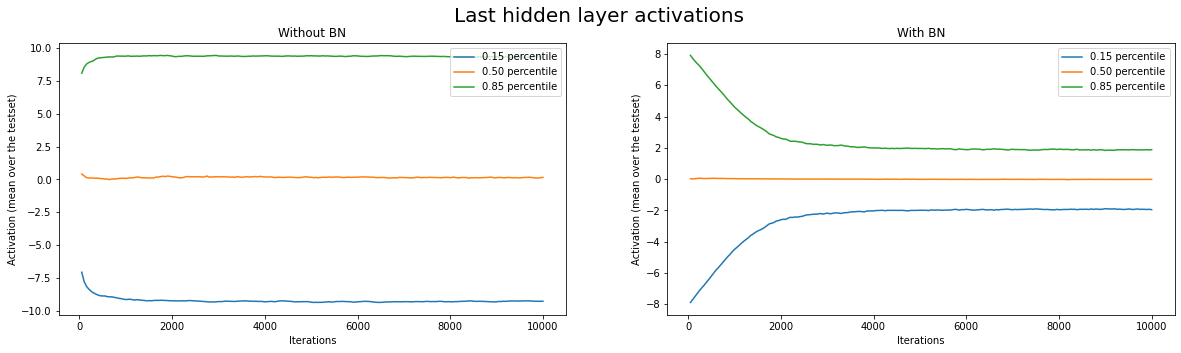

In [13]:

# Display activations
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # -- All iterations
    # Baseline
    ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('Last hidden layer activations', fontsize=20)
    plt.show()
    



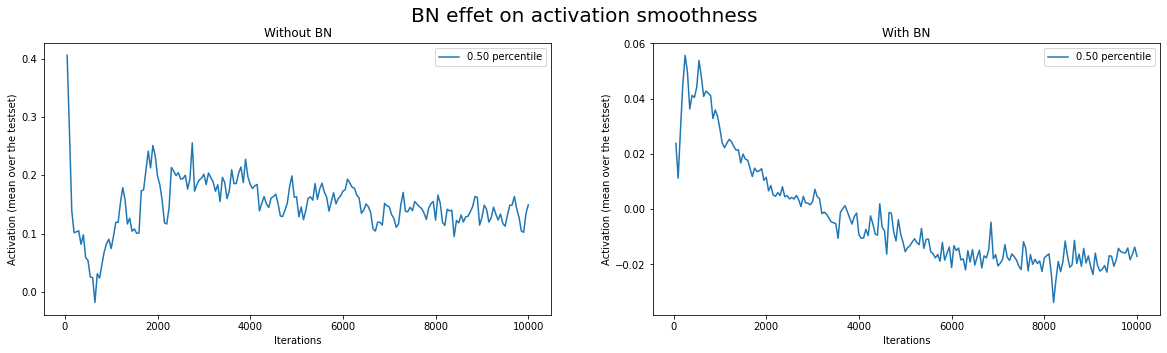

In [14]:
# -- Smallest window to visualize smoothing effect
small_window = 250

if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # Baseline
    ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
#    ax[0].set_xlim(100, 500)
#    ax[0].set_ylim(-10, -6)
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
#    ax[1].set_xlim(100, 500)
#    ax[1].set_ylim(-2, 2)
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('BN effet on activation smoothness', fontsize=20)
    plt.show()
    



As stated at the beginning, normalizing the model's input those small dataset & network mitigates the BN smoothing effect on hidden layers activations.


Without input normalization, the hidden layers activations curves are similar to the original paper's ones :

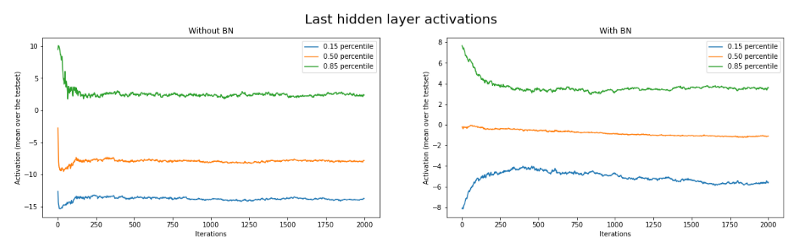

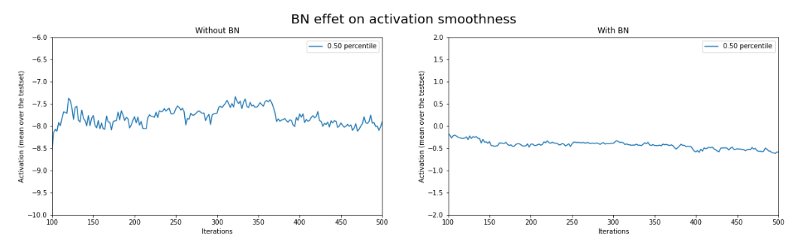
